In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from sklearn.neighbors import LocalOutlierFactor

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('../day6/data/Anomaly_bank_transactions_data_2.csv')
data.head()

,TransactionID,AccountID,TransactionAmount,TransactionDate,TransactionType,Location,DeviceID,IP Address,MerchantID,Channel,CustomerAge,CustomerOccupation,TransactionDuration,LoginAttempts,AccountBalance,PreviousTransactionDate
0,TX000001,AC00128,14.09,2023-04-11 16:29:14,Debit,San Diego,D000380,162.198.218.92,M015,ATM,70,Doctor,81,1,5112.21,2024-11-04 08:08:08
1,TX000002,AC00455,376.24,2023-06-27 16:44:19,Debit,Houston,D000051,13.149.61.4,M052,ATM,68,Doctor,141,1,13758.91,2024-11-04 08:09:35
2,TX000003,AC00019,126.29,2023-07-10 18:16:08,Debit,Mesa,D000235,215.97.143.157,M009,Online,19,Student,56,1,1122.35,2024-11-04 08:07:04
3,TX000004,AC00070,184.50,2023-05-05 16:32:11,Debit,Raleigh,D000187,200.13.225.150,M002,Online,26,Student,25,1,8569.06,2024-11-04 08:09:06
4,TX000005,AC00411,13.45,2023-10-16 17:51:24,Credit,Atlanta,D000308,65.164.3.100,M091,Online,26,Student,198,1,7429.40,2024-11-04 08:06:39


In [3]:
print("Shape of the dataset:",data.shape)

Shape of the dataset: (2512, 16)


In [4]:
print(f'Missing values: {data.isna().sum().sum()}')
print(f'Duplicated values: {data.duplicated().sum()}')

Missing values: 0
Duplicated values: 0


In [5]:
data.describe()

,TransactionAmount,CustomerAge,TransactionDuration,LoginAttempts,AccountBalance
count,2512.000000,2512.000000,2512.000000,2512.000000,2512.000000
mean,297.593778,44.673965,119.643312,1.124602,5114.302966
std,291.946243,17.792198,69.963757,0.602662,3900.942499
min,0.260000,18.000000,10.000000,1.000000,101.250000
25%,81.885000,27.000000,63.000000,1.000000,1504.370000
50%,211.140000,45.000000,112.500000,1.000000,4735.510000
75%,414.527500,59.000000,161.000000,1.000000,7678.820000
max,1919.110000,80.000000,300.000000,5.000000,14977.990000


In [6]:
print("Unique Values in Each Column:")
print(data.nunique())

Unique Values in Each Column:
TransactionID              2512
AccountID                   495
TransactionAmount          2455
TransactionDate            2512
TransactionType               2
Location                     43
DeviceID                    681
IP Address                  592
MerchantID                  100
Channel                       3
CustomerAge                  63
CustomerOccupation            4
TransactionDuration         288
LoginAttempts                 5
AccountBalance             2510
PreviousTransactionDate     360
dtype: int64


In [7]:
num_cols = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = data.select_dtypes(include=['object']).columns.tolist()
print('numerical data',num_cols)
print('category data',cat_cols)

numerical data ['TransactionAmount', 'CustomerAge', 'TransactionDuration', 'LoginAttempts', 'AccountBalance']
category data ['TransactionID', 'AccountID', 'TransactionDate', 'TransactionType', 'Location', 'DeviceID', 'IP Address', 'MerchantID', 'Channel', 'CustomerOccupation', 'PreviousTransactionDate']


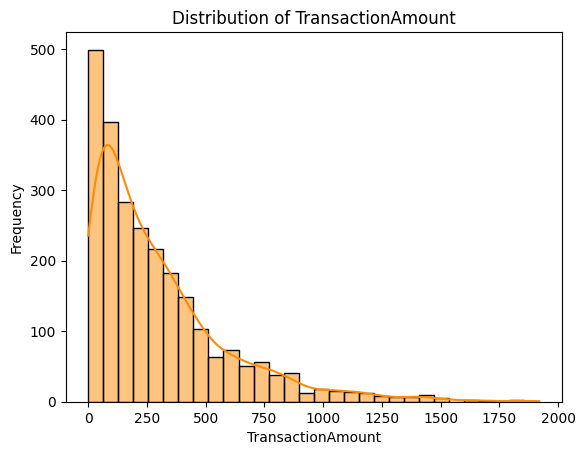

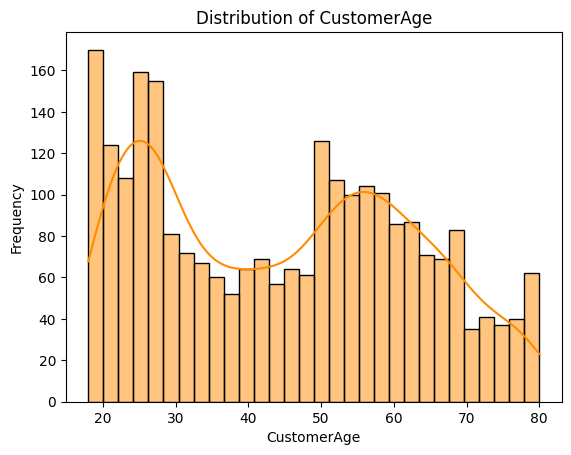

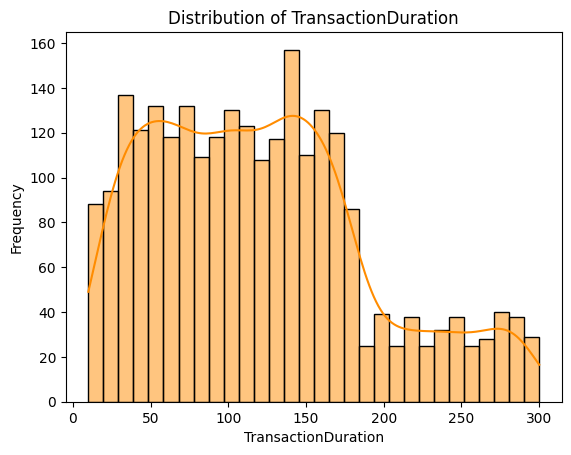

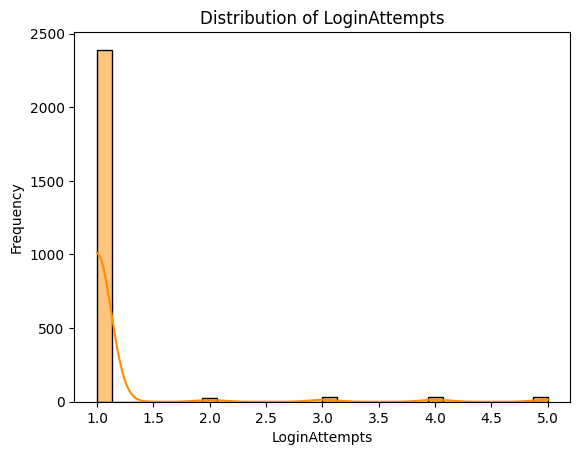

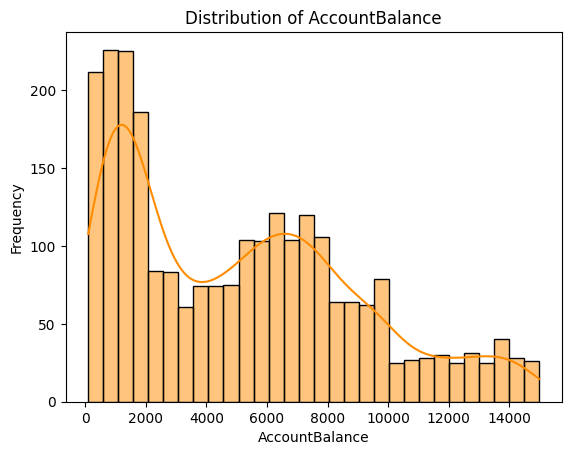

In [8]:
for c in num_cols:
    plt.Figure(figsize=(8,5))
    sns.histplot(data[c], bins=30, kde=True, color='#ff8c00')
    plt.title(f'Distribution of {c}')
    plt.xlabel(c)
    plt.ylabel('Frequency')
    plt.show()

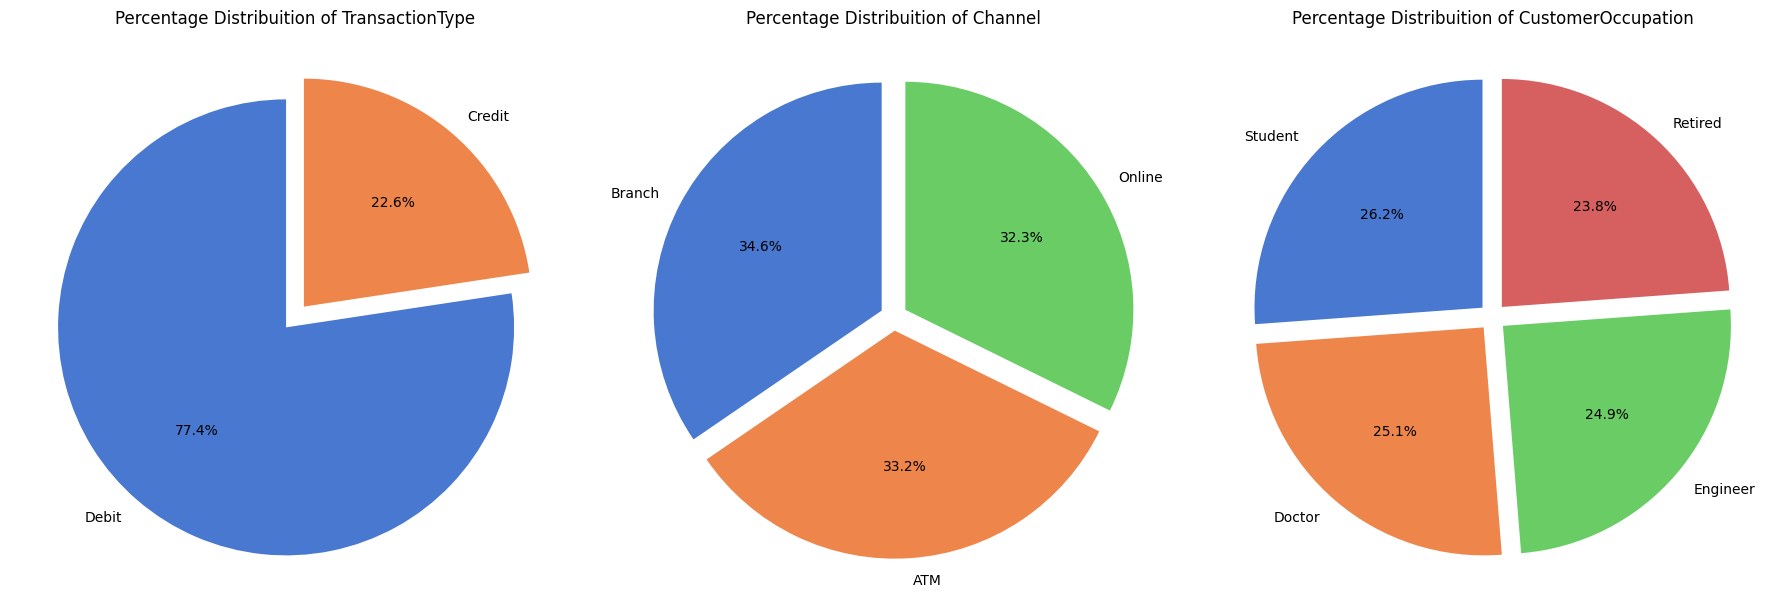

In [9]:
plt.figure(figsize=(18,6))
cat_cols = ['TransactionType', 'Channel', 'CustomerOccupation']
for i, col in enumerate(cat_cols):
    plt.subplot(1,3,i+1)
    value_counts = data[col].value_counts()
    value_counts.plot.pie(autopct='%1.1f%%', colors=sns.color_palette('muted'),startangle=90, explode=[0.06] * value_counts.nunique())
    plt.title(f'Percentage Distribuition of {col}')
    plt.ylabel('')
plt.tight_layout()
plt.show()

In [10]:
features = ['TransactionAmount', 'TransactionDuration']
X = data[features].copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

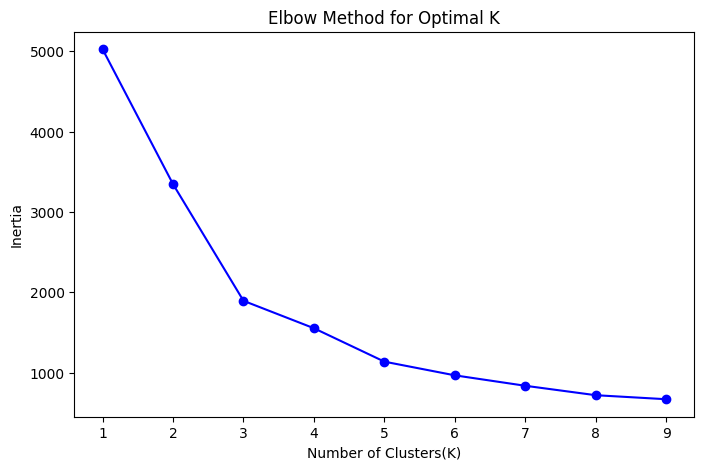

In [11]:
inertia = []
K = range(1,10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=21)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
plt.figure(figsize=(8,5))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of Clusters(K)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()

In [12]:
kmeans = KMeans(n_clusters=3, random_state=21)
kmeans.fit(X_scaled)

data['Cluster'] = kmeans.labels_
data['DistanceToCentroid'] = np.linalg.norm(X_scaled - kmeans.cluster_centers_[kmeans.labels_], axis=1)

threshold = data['DistanceToCentroid'].quantile(0.95)
potential_frauds = data[data['DistanceToCentroid'] > threshold]
print(f"number of potential fraud: {len(potential_frauds)}")
display(potential_frauds)

number of potential fraud: 126


,TransactionID,AccountID,TransactionAmount,TransactionDate,TransactionType,Location,DeviceID,IP Address,MerchantID,Channel,CustomerAge,CustomerOccupation,TransactionDuration,LoginAttempts,AccountBalance,PreviousTransactionDate,Cluster,DistanceToCentroid
74,TX000075,AC00265,1212.51,2023-10-04 16:36:29,Debit,Indianapolis,D000231,193.83.0.183,M036,Branch,20,Student,24,1,605.95,2024-11-04 08:06:51,2,1.866468
85,TX000086,AC00098,1340.19,2023-09-29 17:22:10,Credit,Austin,D000574,165.114.224.47,M012,Online,54,Engineer,30,1,8654.28,2024-11-04 08:06:53,2,2.151389
141,TX000142,AC00114,1049.92,2023-10-23 16:50:33,Debit,Detroit,D000522,121.67.144.20,M052,ATM,80,Retired,21,1,2037.85,2024-11-04 08:10:34,2,1.555073
142,TX000143,AC00163,227.14,2023-07-03 17:42:08,Debit,Charlotte,D000439,197.162.55.147,M057,ATM,18,Student,294,1,341.94,2024-11-04 08:11:34,1,1.507642
146,TX000147,AC00385,973.39,2023-08-30 17:23:20,Debit,Sacramento,D000292,202.194.199.70,M026,Branch,77,Retired,296,1,2042.22,2024-11-04 08:11:44,2,2.637254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2414,TX002415,AC00028,1664.33,2023-09-25 17:11:19,Debit,San Antonio,D000072,116.106.207.139,M064,Branch,18,Student,65,1,1588.31,2024-11-04 08:07:07,2,2.972369
2439,TX002440,AC00439,538.17,2023-09-26 17:27:17,Credit,Washington,D000430,116.44.12.250,M055,Branch,27,Engineer,252,1,5908.04,2024-11-04 08:10:25,1,1.476902
2445,TX002446,AC00439,403.01,2023-09-04 17:32:35,Debit,Washington,D000677,223.32.70.156,M029,Online,63,Doctor,286,3,10513.52,2024-11-04 08:09:32,1,1.558406
2458,TX002459,AC00312,430.83,2023-08-14 16:09:21,Debit,Los Angeles,D000195,87.50.72.69,M079,Branch,18,Student,292,1,941.49,2024-11-04 08:07:49,1,1.678658


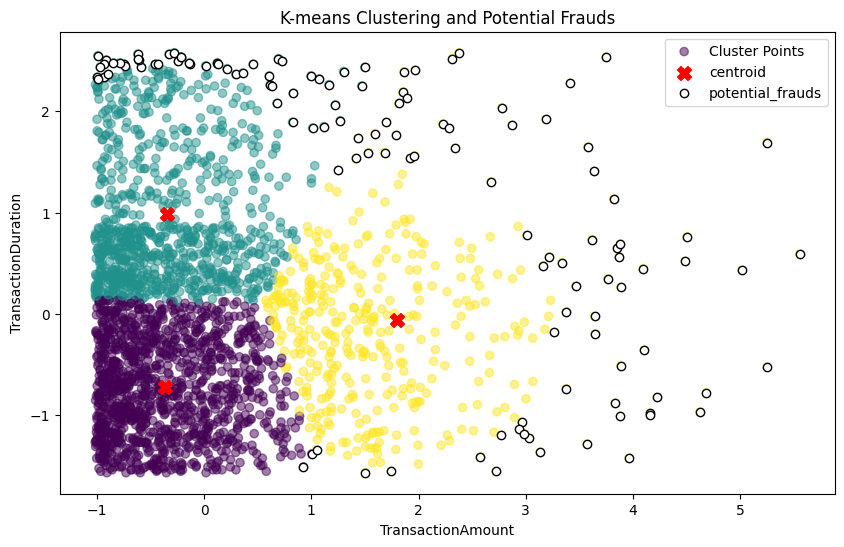

In [13]:
plt.figure(figsize=(10,6))

#plot clusters
scatter = plt.scatter(X_scaled[:,0], X_scaled[:,1], c=kmeans.labels_, cmap='viridis', alpha=0.5, label='Cluster Points')
#plot cluster centroids
centroids = plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], s=100, c='red', marker='X', label='centroid')
#plot potential frauds
frauds = plt.scatter(X_scaled[potential_frauds.index, 0], X_scaled[potential_frauds.index, 1], c='w', label = 'potential_frauds', edgecolors='k')

plt.xlabel(features[0])
plt.ylabel(features[1])
plt.title('K-means Clustering and Potential Frauds')
plt.legend(loc='best')
plt.show()

DBSCAN

In [16]:
#Map the cluster labels to descriptive names
label_mapping = {
    -1:'Fraud (Outliers)',
    0:'Normal',
    1:'Suspicious Group 1',
    2:'Suspicious Group 2',
    3:'Suspicious Group 3',
    4:'Suspicious Group 4',
}
#Select relavant features for DBSCAN
features = ['TransactionAmount', 'TransactionDuration', 'AccountBalance', 'LoginAttempts']
X = data[features].copy()
X = X.fillna(X.mean())

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

dbscan = DBSCAN(eps=1.5, min_samples=5)
dbscan.fit(X_scaled)

data['DBSCAN Cluster'] = dbscan.labels_
data['Cluster_Description'] = data['DBSCAN Cluster'].map(label_mapping)

# Identify outliers (noise points) labeled as -1
potential_frauds = data[data['DBSCAN Cluster'] == -1]
print(f"Number of potential frauds detected by DBSCAN: {len(potential_frauds)}")
display(potential_frauds.head(5))

Number of potential frauds detected by DBSCAN: 17


,TransactionID,AccountID,TransactionAmount,TransactionDate,TransactionType,Location,DeviceID,IP Address,MerchantID,Channel,CustomerAge,CustomerOccupation,TransactionDuration,LoginAttempts,AccountBalance,PreviousTransactionDate,Cluster,DistanceToCentroid,DBSCAN Cluster,Cluster_Description
274,TX000275,AC00454,1176.28,2023-12-20 16:08:02,Credit,Kansas City,D000476,50.202.8.53,M074,ATM,54,Engineer,174,5,323.69,2024-11-04 08:11:44,2,1.476264,-1,Fraud (Outliers)
454,TX000455,AC00264,611.11,2023-10-18 18:32:31,Debit,Detroit,D000215,141.201.46.191,M045,ATM,20,Student,282,4,919.84,2024-11-04 08:11:12,1,1.945919,-1,Fraud (Outliers)
653,TX000654,AC00423,1919.11,2023-06-27 17:48:25,Debit,Portland,D000191,207.157.126.125,M033,ATM,30,Doctor,161,1,11090.24,2024-11-04 08:10:27,2,3.814445,-1,Fraud (Outliers)
693,TX000694,AC00011,733.29,2023-03-15 18:42:16,Debit,Virginia Beach,D000618,16.51.235.240,M032,ATM,52,Doctor,94,5,10427.00,2024-11-04 08:07:12,2,0.429074,-1,Fraud (Outliers)
754,TX000755,AC00153,84.34,2023-06-08 16:27:56,Debit,Memphis,D000493,200.136.146.93,M039,Online,58,Retired,248,3,5313.97,2024-11-04 08:09:31,1,0.930668,-1,Fraud (Outliers)


ISOLATION FOREST

In [20]:
outlier_mapping = {1:'Normal', -1:'potential_frauds'}
features = ['TransactionAmount', 'TransactionDuration', 'AccountBalance', 'LoginAttempts'] 
X = data[features].copy()
X = X.fillna(X.mean())

iso_forest = IsolationForest(n_estimators=100, contamination=0.04, random_state=42)
iso_forest.fit(X_scaled)

data['AnomalyScore'] = iso_forest.decision_function(X_scaled)
data['IsAnomaly'] = iso_forest.predict(X_scaled)

data['AnomalyLabel'] = data['IsAnomaly'].map(outlier_mapping)

potential_frauds = data[data['IsAnomaly'] == -1]
print(f"Number of potential frauds detected: {len(potential_frauds)}")
display(potential_frauds.head(5))

Number of potential frauds detected: 101


,TransactionID,AccountID,TransactionAmount,TransactionDate,TransactionType,Location,DeviceID,IP Address,MerchantID,Channel,...,LoginAttempts,AccountBalance,PreviousTransactionDate,Cluster,DistanceToCentroid,DBSCAN Cluster,Cluster_Description,AnomalyScore,IsAnomaly,AnomalyLabel
26,TX000027,AC00441,246.93,2023-04-17 16:37:01,Debit,Miami,D000046,55.154.161.250,M029,ATM,...,5,673.35,2024-11-04 08:11:38,1,0.471919,2,Suspicious Group 2,-0.062168,-1,potential_frauds
32,TX000033,AC00060,396.45,2023-09-25 16:26:00,Debit,New York,D000621,133.67.250.163,M007,ATM,...,3,9690.15,2024-11-04 08:11:13,1,0.744471,1,Suspicious Group 1,-0.001199,-1,potential_frauds
85,TX000086,AC00098,1340.19,2023-09-29 17:22:10,Credit,Austin,D000574,165.114.224.47,M012,Online,...,1,8654.28,2024-11-04 08:06:53,2,2.151389,0,Normal,-0.005225,-1,potential_frauds
91,TX000092,AC00310,223.85,2023-10-02 16:36:10,Debit,Kansas City,D000481,133.223.159.151,M009,ATM,...,4,2929.91,2024-11-04 08:08:01,0,0.230996,4,Suspicious Group 4,-0.016907,-1,potential_frauds
146,TX000147,AC00385,973.39,2023-08-30 17:23:20,Debit,Sacramento,D000292,202.194.199.70,M026,Branch,...,1,2042.22,2024-11-04 08:11:44,2,2.637254,0,Normal,-0.003922,-1,potential_frauds


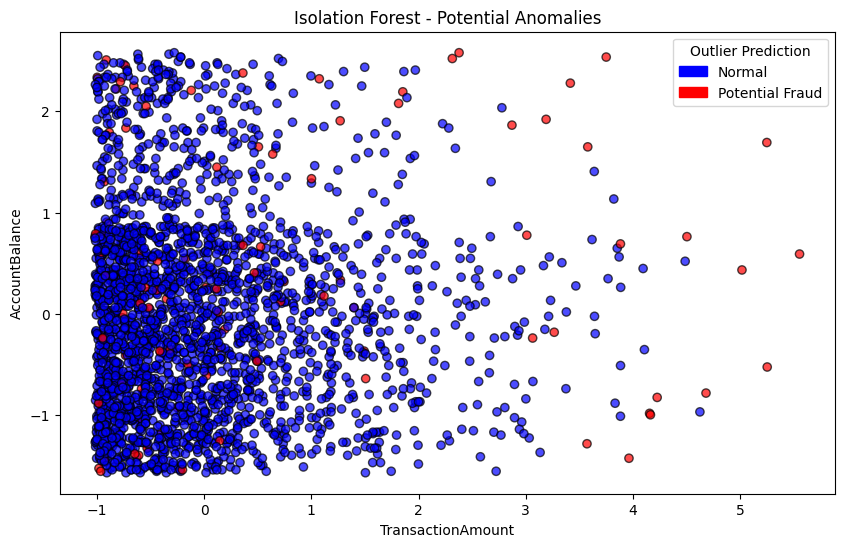

In [22]:
colors = np.where(data['IsAnomaly'] == -1, 'r', 'b')

plt.figure(figsize=(10,6))
plt.scatter(X_scaled[:,0], X_scaled[:,1], c=colors, cmap='coolwarm', alpha=0.7, edgecolors='k', label='Data Points')

import matplotlib.patches as mpatches
normal_patch = mpatches.Patch(color='b', label='Normal')
fraud_patch = mpatches.Patch(color='r', label='Potential Fraud')
plt.legend(handles=[normal_patch, fraud_patch], title='Outlier Prediction')

plt.title("Isolation Forest - Potential Anomalies")
plt.xlabel(features[0])
plt.ylabel(features[2])
plt.show()